Look out for Dummy Variable Trap (might not be relevant for cuisine types since they can overlap)

In [830]:
from bs4 import BeautifulSoup
import re
import json
import requests
import time
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import nltk
from collections import defaultdict
from copy import deepcopy
#nltk.download('wordnet')
from nltk.corpus import wordnet as wn
import statsmodels.api as sm
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
import seaborn as sns
import itertools
import diagnostic_plots as dp_plot

min_max_scaler = preprocessing.MinMaxScaler()
% matplotlib inline

In [344]:
class Restaurant:
    
    def __init__(self, json):
        self.Name = json['name']
        self.Geo = json['geo']
        self.Types = json['servesCuisine']
        self.Menudf = create_menudf(json, json['name'])
        
    def get_coordinates(self):
        coords = (self.Geo['latitude'], self.Geo['longitude'])
        return coords

In [832]:
# Scraping Functions
def gather_allmenus_links(restaurant_type):

    major_url = f'https://www.allmenus.com/ca/san-francisco/-/{restaurant_type.lower()}/'
    major_r = requests.get(major_url).text
    major_soup = BeautifulSoup(major_r, 'html5lib')
    major_parent = major_soup.find_all('section', class_ = 'restaurant-list-container s-col-md-8')[0]
    r_list = major_parent.find_all('li', class_  = 'restaurant-list-item clearfix')
    
    url_list = []
    for link in r_list:
        r_url = link.find('a')
        url_list.append(f'https://www.allmenus.com{r_url.get("href")}')
    
    return set(url_list)


def scrape_json(url):
    
    soup = BeautifulSoup(requests.get(url).text, 'html5lib')
    parent = soup.find_all('head')[0]
    children = parent.find_all("script")
    menu_child = children[1]
    json_html = re.sub(r'\r|\n', '', menu_child.text)
    return json.loads(json_html)

# Interpreting Data Functions
def get_dish_features(entry, name_list, desc_list, price_list):
    
    name_list.append(entry['name'])
    desc_list.append(entry['description'])
    # This is to catch entries missing price
    try:
        offers_list = entry['offers']
        first_offer = offers_list[0]
        price_list.append(first_offer['Price'])
    except:
        price_list.append(None)

def create_menudf(json, Res_Name):
    
    total_df = pd.DataFrame(columns = ['Menu Section', 'Menu Section Desc', 'Dish Name', 'Dish Desc', 'Dish Price'])
    
    try:
        menu_info = json['hasMenu'][0]
    except IndexError:
        print(f'No Menu for {Res_Name}')
        return None

    for MenuSections in menu_info['hasMenuSection']:

        # Holding name and description for each menu section
        MenuSectionName = MenuSections['name']
        MenuSectionDesc = MenuSections['description']

        # Lists that get_dish_features will be appending to
        ItemNames = []
        ItemDescs = []
        ItemPrices = []

        for Dish in MenuSections['hasMenuItem']:
            get_dish_features(Dish, ItemNames, ItemDescs, ItemPrices)

        section_df = pd.DataFrame({'Menu Section': MenuSectionName,
                                   'Menu Section Desc': MenuSectionDesc,
                                   'Dish Name': ItemNames,
                                   'Dish Desc': ItemDescs,
                                   'Dish Price': ItemPrices})

        total_df = total_df.append(section_df)

    total_df = total_df.reset_index(drop = True)
    return total_df

# Packaging Functions
def create_rest_pkl(types_list, x, filename):
    
    restaurant_list = []
    urls = []
    
    for rest_type in types_list:
        time.sleep(np.random.poisson(x))
        urls += gather_allmenus_links(rest_type)
    urls = set(urls)
    
    for i, link in enumerate(urls):
        if i % 10 == 0:
            print(i)
        time.sleep(np.random.poisson(x))
        try:
            restaurant_list.append(Restaurant(scrape_json(link)))
        except json.JSONDecodeError:
            print(f"Wasn't able to retrive JSON of: {link}")
        except KeyError:
            print(f"Had trouble processing dict of: {link}")
            
    with open(filename, 'wb') as picklefile: # 'wb' = write binary
        pickle.dump(restaurant_list, picklefile)
        
def grab_nouns(txt):
    split_txt = re.split(r'[ &.]', txt)
    noun_list = []
    for i in split_txt:
        syn_list = wn.synsets(i)
        if len(syn_list) < 1 or len(i) < 3:
            pass
        elif syn_list[0].pos() == 'n':
            first_syn = syn_list[0]
            new_noun = first_syn.name().replace('_', '.').replace('-', '.')
            noun_list.append(new_noun.split('.')[0])
                
    return list(set(noun_list))     

def get_ingredients(alphabet_list, t, filename):
    
    all_ingredients = []
    
    for letter in alphabet_list:
        
        time.sleep(np.random.poisson(t))
        bbc_site = f'https://www.bbc.com/food/ingredients/by/letter/{letter}'
        ingr_soup = BeautifulSoup(requests.get(bbc_site).text, 'html5lib')
        try:
            parent = ingr_soup.find_all('ol', class_ = 'resources-by-letter')[0]
            for item in parent.find_all('li', class_ = 'resource food'):
                link = item.find('a')
                ingr = link.text.lower()
                ingr = re.search(r'\S+', ingr).group()
                ingr_noun = grab_nouns(ingr)
                [all_ingredients.append(i) for i in ingr_noun]

        except IndexError:
            print(f'No ingredients starting with {letter}')
    
    foodwise_url = 'http://www.foodwise.com.au/recipe-room/our-recipe-finder/'
    foodwise_soup = BeautifulSoup(requests.get(foodwise_url).text, 'html5lib')
    
    for i_ingred in foodwise_soup.find_all('li', class_ = 'ingred-link'):
        split_text = re.sub(r'[^a-zA-Z\s]', '', i_ingred.text).lower().split(' ')
        for item in split_text:
            nouns = grab_nouns(item)
            [all_ingredients.append(i) for i in nouns]
    
    #print(all_ingredients)
    all_ingredients = set(all_ingredients)
    
    with open(filename, 'wb') as picklefile: # 'wb' = write binary
        pickle.dump(all_ingredients, picklefile)
        
    #return set(all_ingredients)

def get_mock_price(x, pdict, Ndict):
    try:
        price_list = [pdict[i] / Ndict[i] for i in x]
    except ZeroDivisionError:
        return np.nan
    return np.sum(price_list)

In [674]:
def create_allrestdf(restaurant_list):
    
    # Constants
    # Menu Section Words
    #appetizer_words = ['appetizer', 'starter', 'oyster']
    #appetizer_words = []
    entree_words = ['supper', 'dinner', 'special', 'main', 'entree', 'brunch',
                    'meal', 'salad', 'burger', 'breakfast', 'sandwich', 'pizza',
                   'curry', 'pasta', 'omelet',]
    dessert_words = ['dessert']
    # only look at entrees and desserts
    section_words = set(entree_words + dessert_words)
    # Unallowed words are to remove keywords that signaled large format dishes
    unallowed_words = set(['platter', 'home', 'catering', 'tray'])

    all_types = [] 
    for i_rest in [i.Types for i in restaurant_list]:
        all_types += [i_type.replace(' &amp; ', '-').split( )[0].lower() for i_type in i_rest]

    zip_types = pd.Series(all_types).value_counts()
    excluded_types = ['bar', 'latin', 'middle']
    all_types = [i[1] for i in list(zip(zip_types,zip_types.index)) if (i[0] >= 20) & (i[1] not in excluded_types)]
    
    
    
    allrest_df = pd.DataFrame()
    for i_rest in restaurant_list:
        if type(i_rest.Menudf) != pd.DataFrame:
            pass
        else:
            df = i_rest.Menudf
            df['Restaurant Name'] = i_rest.Name
            df['Latitude'] = i_rest.get_coordinates()[0]
            df['Longitude'] = i_rest.get_coordinates()[1]
            df['Restaurant Types'] = [i_rest.Types] * len(df)
            allrest_df = allrest_df.append(df)

    # Filters
    allrest_df.fillna(value = np.nan, inplace = True)
    allrest_df.dropna(how = 'any', inplace = True)
    allrest_df = allrest_df[allrest_df['Dish Price'] != '']
    allrest_df[['Longitude', 'Latitude', 'Dish Price']] = allrest_df[['Longitude', 'Latitude', 'Dish Price']].applymap(float)
    # Delete any Dish less than $1
    allrest_df = allrest_df[allrest_df['Dish Price'] > 1]

    # Reordering
    allrest_df = allrest_df[['Dish Price', 'Restaurant Name', 'Restaurant Types', 'Longitude', 'Latitude',
                         'Menu Section', 'Menu Section Desc', 'Dish Name', 'Dish Desc']]

    # Creating Columns
    allrest_df['Total Dish Text'] = allrest_df['Dish Name'] + ' ' +  allrest_df['Dish Desc'].apply(lambda x: x.lower())
    allrest_df['Dish Text Length'] = allrest_df['Total Dish Text'].apply(len)
    allrest_df['Dish Nouns'] = allrest_df['Total Dish Text'].apply(grab_nouns)
    allrest_df['Section Nouns'] = allrest_df['Menu Section'].apply(grab_nouns).apply(tuple)
    
    
    # Make sure that dishes are entrees, desserts, or appetizers
    allrest_df['Allowable Section'] = allrest_df['Section Nouns'].apply(lambda x: True 
                                                                    if (len(section_words.intersection(set(x))) > 0) &
                                                                        (len(unallowed_words.intersection(set(x))) < 1)
                                                                    else False)
    allrest_df['Ingredients'] = allrest_df['Dish Nouns'].apply(lambda x: all_ingredients.intersection(set(x)))
    allrest_df['N_Ingredients'] = allrest_df['Ingredients'].apply(len)

    allrest_df['Restaurant Types'] = (allrest_df['Restaurant Types']
                                    .apply(lambda x: [i.replace(' &amp; ', '-').lower() for i in x])
                                    .apply(tuple))
    allrest_df['N_Types'] = allrest_df['Restaurant Types'].apply(len)
    
    
    log_cols = ['Longitude', 'Latitude', 'Dish Text Length', 'N_Ingredients']
    for i in log_cols:
        allrest_df[f'log_{i}'] = allrest_df[i].apply(abs).apply(np.log10)
        
    # Creating categorical features
    for i_type in all_types:
        allrest_df[f'{i_type}_Type'] = allrest_df['Restaurant Types'].apply(lambda x: 1 if f'{i_type}' in x else 0)

    # Dropping rows and columns
    allrest_df = allrest_df[allrest_df['Allowable Section'] == True].reset_index(drop = True)
    allrest_df = allrest_df[allrest_df['N_Ingredients'] != 0]
    # Drop columns not used for calculation
    allrest_df = allrest_df.drop(labels = ['Menu Section Desc', 'Dish Name', 'Menu Section', 
                                       'Dish Desc', 'Total Dish Text', 'Restaurant Name', 'Restaurant Types',
                                       'Allowable Section', 'Dish Nouns'], axis = 1)
    
    return allrest_df

In [838]:
def ttsplit(base_df, dropcol_ls, power2_ls, lc_price, hc_price, N_ingr, drop_indexes = []):
    
    y_vals = base_df.iloc[:, 0]
    # Applying log10 to the price
    y_vals = y_vals.apply(np.log)
    X_vals = base_df.iloc[:, 1:]
    
    Xtrain_df, Xtest_df, ytrain_df, ytest_df = train_test_split(X_vals, y_vals, test_size=0.3, random_state = 42)
    
    price_df = pd.concat([ytrain_df, Xtrain_df[['Ingredients', 'N_Ingredients']]], axis = 1)
    
    lowcost_df = price_df[price_df['Dish Price'] < lc_price][['Dish Price', 'Ingredients']]
    lowcost_list = pd.Series(np.sum(lowcost_df['Ingredients'].apply(list).values))
    lc = set(lowcost_list.value_counts()[:N_ingr].index.values)

    midcost_df = price_df[(price_df['Dish Price'] >= lc_price) & (base_df['Dish Price'] < hc_price)][['Dish Price', 'Ingredients']]
    midcost_list = pd.Series(np.sum(midcost_df['Ingredients'].apply(list).values))
    mc = set(midcost_list.value_counts()[:N_ingr].index.values)

    highcost_df = price_df[(price_df['Dish Price'] >= hc_price)][['Dish Price', 'Ingredients']]
    highcost_list = pd.Series(np.sum(highcost_df['Ingredients'].apply(list).values))
    hc = set(highcost_list.value_counts()[:N_ingr].index.values)

    #hc_only = hc - lc - mc
    #hc_mc = hc - mc
    #hc_lc = hc - lc
    #mc_only = mc - lc - hc
    #mc_lc = hc - lc
    lc_only = lc - mc - hc
    
    price_df['N/P'] = np.round(price_df['Dish Price'] / price_df['N_Ingredients'], 2)
    zip_list = list(zip(price_df['Ingredients'], price_df['N/P']))
    tup_list = [[(i, j[1]) for i in j[0]] for j in zip_list]
    price_df['Tuples'] = tup_list
    price_list = np.sum(price_df['Tuples'].values)
    
    N_dict = defaultdict(int)
    price_dict = defaultdict(float)
    for entry in price_list:
        price_dict[entry[0]] += entry[1]
        N_dict[entry[0]] += 1

        
    for i_df in [Xtrain_df, Xtest_df]:
        i_df['LC_Ingredients'] = i_df['Ingredients'].apply(lambda x: len(lc.intersection(x)))
        #i_df['MC_Ingredients'] = i_df['Ingredients'].apply(lambda x: len(mc.intersection(x)))
        #i_df['HC_Ingredients'] = i_df['Ingredients'].apply(lambda x: len(hc.intersection(x)))
        i_df['LC_Only'] = i_df['Ingredients'].apply(lambda x: len(lc_only.intersection(x)))
        #i_df['MC_Only'] = i_df['Ingredients'].apply(lambda x: len(mc_only.intersection(x)))
        #i_df['HC_Only'] = i_df['Ingredients'].apply(lambda x: len(hc_only.intersection(x)))    
        i_df['Mock_Price'] = i_df['Ingredients'].apply(lambda x: get_mock_price(x, price_dict, N_dict))
        #i_df.drop(columns = ['Ingredients', 'Section Nouns'], inplace = True)
        #for elem in power2_ls:
        #    print(elem)
        #    i_df[f'{i[0]} x {i[1]}'] = i_df[i[0]] * i_df[i[1]]
        #i_df.drop(labels = dropcol_ls, axis = 1, inplace = True)

        #for j in cutdown3_list:
        #    i_df[f'{j[0]} x {j[1]} x {j[2]}'] = i_df[j[0]] * i_df[j[1]]  * i_df[j[2]]
    
    for elem in power2_ls:
        Xtrain_df[f'{elem[0]} x {elem[1]}'] = Xtrain_df[elem[0]] * Xtrain_df[elem[1]]
        Xtest_df[f'{elem[0]} x {elem[1]}'] = Xtest_df[elem[0]] * Xtest_df[elem[1]]

    if len(drop_indexes) > 0:
        Xtrain_df.drop(index = drop_indexes, inplace = True)
        ytrain_df.drop(index = drop_indexes, inplace = True)
    
    Xtrain_df.drop(columns = ['Ingredients', 'Section Nouns'], inplace = True)
    Xtest_df.drop(columns = ['Ingredients', 'Section Nouns'], inplace = True)
    
    return (Xtrain_df, Xtest_df, ytrain_df, ytest_df)

In [351]:
# Constants
multi_list1 = ['american', 'mediterranean', 'mexican']
multi_list2 = ['cajun-creole', 'pakistani', 'african']

['american', 'mexican', 'mediterranean', 'sandwiches', 'local/organic', 'cocktails', 'californian', 'coffee-tea', 'tapas', 'seafood', 'diner', 'cajun-creole']


In [ ]:
# Webscraping and pickling
#create_rest_pkl(multi_list1, 3, 'multi_list1.pkl' )
#create_rest_pkl(multi_list2, 3, 'multi_list2.pkl' )
get_ingredients(list(string.ascii_lowercase), 3, 'ingredients_list2.pkl')

In [ ]:
with open('multi_list.pkl', 'rb') as picklefile:
    rest_list1 = pickle.load(picklefile)
with open('multi_list2.pkl', 'rb') as picklefile:
    rest_list2 = pickle.load(picklefile)
# Get base words of ingredient list
with open('ingredients_list2.pkl', 'rb') as picklefile: # 'wb' = write binary
    all_ingredients = pickle.load(picklefile)
all_ingredients = set(all_ingredients)
all_ingredients

In [610]:
# Grabbed restaurant types
rest_list = rest_list1 + rest_list2

Screening words for menu sections

In [709]:
base_cols = ['Mock_Price', 'LC_Ingredients', 'HC_Ingredients', 'HCMC_Ingredients', 
             'HCLC_Ingredients', 'MCLC_Ingredients', 'Longitude', 'Latitude',
             'MC_Ingredients', 'N_Types', 'N_Ingredients']
creation_list = ['log_Longitude','log_Latitude', 'Mock_Price','N_Types', 'N_Ingredients', 'log_Dish Text Length', 'log_N_Ingredients']
# creation_list = ['Mock_Price', 'LC_Ingredients', 'HC_Ingredients', 'HCMC_Ingredients', 
#               'HCLC_Ingredients', 'MCLC_Ingredients','MC_Ingredients', 'N_Types', 'N_Ingredients']
#creation_list = base_cols
possible_list = [i for i in itertools.product(creation_list, creation_list)]
cutdown_list = set([tuple(sorted(i)) for i in possible_list])
possible3_list = [i for i in itertools.product(creation_list, creation_list, creation_list)]
cutdown3_list = set([tuple(sorted(i)) for i in possible3_list])

dropcol_list = ['N_Ingredients x N_Ingredients', 'log_Dish Text Length x log_Longitude','log_Longitude x log_N_Ingredients', 'N_Types x log_Dish Text Length','log_Latitude x log_Longitude', 'N_Ingredients x log_N_Ingredients','log_Dish Text Length x log_N_Ingredients', 'local/organic_Type','N_Types x log_N_Ingredients', 'Mock_Price x log_N_Ingredients']

three_dropcol_list = ['Mock_Price x log_Longitude x log_N_Ingredients', 'N_Ingredients x N_Ingredients x log_N_Ingredients',
                     'Mock_Price x Mock_Price x Mock_Price', 'N_Ingredients x log_Latitude x log_N_Ingredients', 
                     'og_Latitude x log_Longitude x log_Longitude', 'Mock_Price x log_Dish Text Length x log_Latitude',
                     'N_Types x N_Types x log_Longitude', 'Mock_Price x N_Ingredients x log_Latitude', 
                     'N_Ingredients x N_Ingredients x log_Longitude', 'log_Dish Text Length x log_N_Ingredients x log_N_Ingredients',
                     'log_N_Ingredients x log_N_Ingredients x log_N_Ingredients', 'Mock_Price x N_Ingredients x log_N_Ingredients', 
                     'log_Longitude x log_Longitude x log_N_Ingredients', 'Mock_Price x N_Ingredients x log_Dish Text Length', 
                     'N_Ingredients x N_Ingredients x N_Types', 'log_Latitude x log_Latitude x log_Latitude', 
                     'N_Ingredients x N_Types x N_Types', 'N_Ingredients x log_Latitude x log_Latitude', 
                     'N_Types x log_Dish Text Length x log_Longitude', 'N_Ingredients x log_Dish Text Length x log_N_Ingredients', 
                     '']

In [737]:
LC_list = [5, 10, 15]
HC_list = [20, 25, 30]
Nitems_list = [10, 20, 30, 40]
metrics = []

model_df = deepcopy(total_df)
acc = 0

for i in LC_list:
    for j in HC_list:
        for k in Nitems_list:
            params = (i, j, k)
            print((acc, params))
            X_train, X_test, y_train, y_test = ttsplit(model_df, dropcol_list, cutdown_list, i, j, k)
            linmodel = sm.OLS(y_train, sm.add_constant(X_train)).fit()
            y_train_pred = linmodel.predict(sm.add_constant(X_train))
            values = (params, linmodel.rsquared_adj, mean_squared_error(y_train, linmodel.predict(sm.add_constant(X_train))))
            metrics.append(values)
            acc += 1

(0, (5, 20, 10))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

(1, (5, 20, 20))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(2, (5, 20, 30))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(3, (5, 20, 40))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(4, (5, 25, 10))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(5, (5, 25, 20))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(6, (5, 25, 30))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(7, (5, 25, 40))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(8, (5, 30, 10))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(9, (5, 30, 20))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(10, (5, 30, 30))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(11, (5, 30, 40))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(12, (10, 20, 10))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(13, (10, 20, 20))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(14, (10, 20, 30))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(15, (10, 20, 40))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(16, (10, 25, 10))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(17, (10, 25, 20))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(18, (10, 25, 30))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(19, (10, 25, 40))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(20, (10, 30, 10))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(21, (10, 30, 20))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(22, (10, 30, 30))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(23, (10, 30, 40))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(24, (15, 20, 10))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(25, (15, 20, 20))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(26, (15, 20, 30))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(27, (15, 20, 40))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(28, (15, 25, 10))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(29, (15, 25, 20))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(30, (15, 25, 30))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(31, (15, 25, 40))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(32, (15, 30, 10))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(33, (15, 30, 20))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(34, (15, 30, 30))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


(35, (15, 30, 40))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


In [742]:
items10_rsquared = []
items20_rsquared = []
items30_rsquared = []
items40_rsquared = []

items10_mse = []
items20_mse = []
items30_mse = []
items40_mse = []

items_rsquared = [items10_rsquared, items20_rsquared, items30_rsquared, items40_rsquared]
items_mse = [items10_mse, items20_mse, items30_mse, items40_mse]

for i in metrics:
    param_tup = i[0]
    if param_tup[2] == 10:
        items_rsquared[0].append(i[1]) 
        items_mse[0].append(i[2])
    elif param_tup[2] == 20:
        items_rsquared[1].append(i[1]) 
        items_mse[1].append(i[2])
    elif param_tup[2] == 30:
        items_rsquared[2].append(i[1]) 
        items_mse[2].append(i[2])
    else:
        items_rsquared[3].append(i[1]) 
        items_mse[3].append(i[2])        

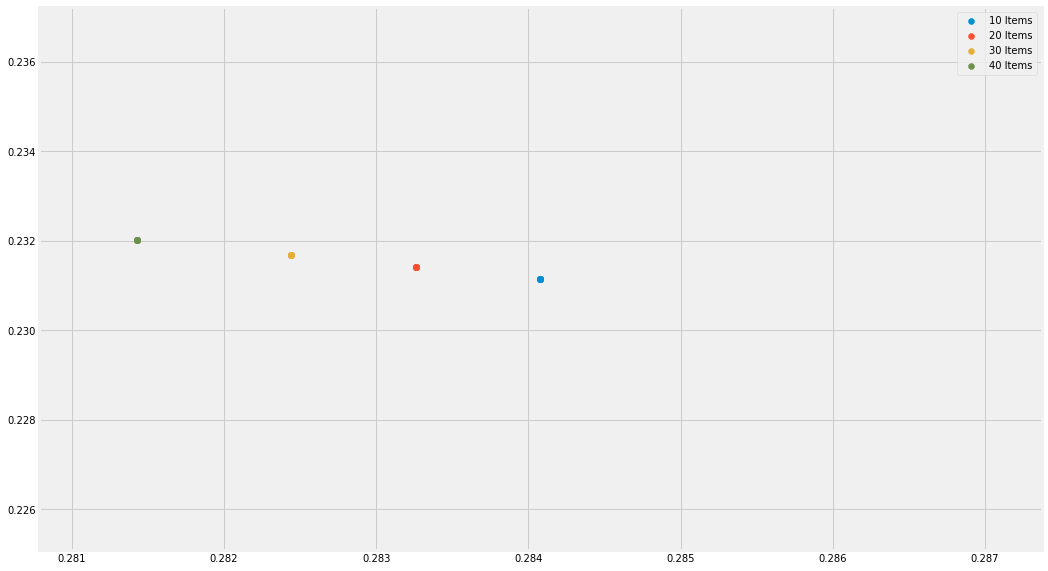

In [769]:
# Seems that 10 items has the strongest effect, lc_price and hc_price don't have effect
plt.scatter(items10_rsquared, items10_mse)
plt.scatter(items20_rsquared, items20_mse)
plt.scatter(items30_rsquared, items30_mse)
plt.scatter(items40_rsquared, items40_mse)
plt.legend(['10 Items', '20 Items', '30 Items', '40 Items']);

In [894]:
from scipy.stats import boxcox

In [895]:
N_ingr = 10
X_train, X_test, y_train, y_test = ttsplit(model_df, dropcol_list, cutdown_list, 10, 30, N_ingr)
linmodel = sm.OLS(y_train, sm.add_constant(X_train)).fit()
y_train_pred = linmodel.predict(sm.add_constant(X_train))
values = (linmodel.rsquared_adj, mean_squared_error(y_train, linmodel.predict(sm.add_constant(X_train))))
linmodel.summary()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [916]:
linmodel = sm.OLS(y_train, sm.add_constant(X_train)).fit()
y_train_pred = linmodel.predict(sm.add_constant(X_train))
values = (linmodel.rsquared_adj, mean_squared_error(y_train, linmodel.predict(sm.add_constant(X_train))))
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Dish Price   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     90.95
Date:                Mon, 16 Jul 2018   Prob (F-statistic):               0.00
Time:                        21:32:41   Log-Likelihood:                -6858.3
No. Observations:               10233   AIC:                         1.382e+04
Df Residuals:                   10182   BIC:                         1.419e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                       -3.719e+10   1.46e+10     -2.549      0.011   -6.58e+10   -8.59e+09
Longitude                                   -3.867e+07   1.54e+07     -2.513      0.012   -6.88e+07    -8.5e+06
Latitude                                     3.263e+06   1.35e+06      2.416      0.016    6.16e+05    5.91e+06
Dish Text Length                               -0.0058      0.001     -6.092      0.000      -0.008      -0.004
N_Ingredients                                -678.8496    309.280     -2.195      0.028   -1285.100     -72.599
N_Types                                       376.8517    184.254      2.045      0.041      15.678     738.026
log_Longitude                                4.152e+10   1.65e+10      2.513      0.012    9.14e+09    7.39e+10
log_Latitude                                 7.483e+08   3.09e+08      2.424      0.015    1.43e+08    1.35e+09
log_Dish Text Length                          840.7183    668.779      1.257      0.209    -470.219    2151.656
log_N_Ingredients                              -4.9615   1428.805     -0.003      0.997   -2805.702    2795.778
american_Type                                  -0.0563      0.013     -4.468      0.000      -0.081      -0.032
mexican_Type                                   -0.1907      0.017    -10.948      0.000      -0.225      -0.157
mediterranean_Type                             -0.0369      0.016     -2.244      0.025      -0.069      -0.005
sandwiches_Type                                -0.1508      0.018     -8.413      0.000      -0.186      -0.116
local/organic_Type                             -0.0223      0.020     -1.107      0.268      -0.062       0.017
cocktails_Type                                  0.0896      0.022      4.013      0.000       0.046       0.133
californian_Type                                0.1393      0.020      6.950      0.000       0.100       0.179
coffee-tea_Type                                -0.1704      0.020     -8.370      0.000      -0.210      -0.130
tapas_Type                                     -0.1185      0.038     -3.110      0.002      -0.193      -0.044
seafood_Type                                    0.2336      0.032      7.232      0.000       0.170       0.297
diner_Type                                      0.0359      0.018      2.046      0.041       0.002       0.070
cajun-creole_Type                              -0.1151      0.037     -3.140      0.002      -0.187      -0.043
LC_Ingredients                                354.9156    145.307      2.443      0.015      70.086     639.745
LC_Only                                      -354.9476    145.307     -2.443      0.015    -639.778     -70.117
Mock_Price                                   1398.2556    6

In [778]:
values

(0.30215724528609744, 0.2249416160621481)

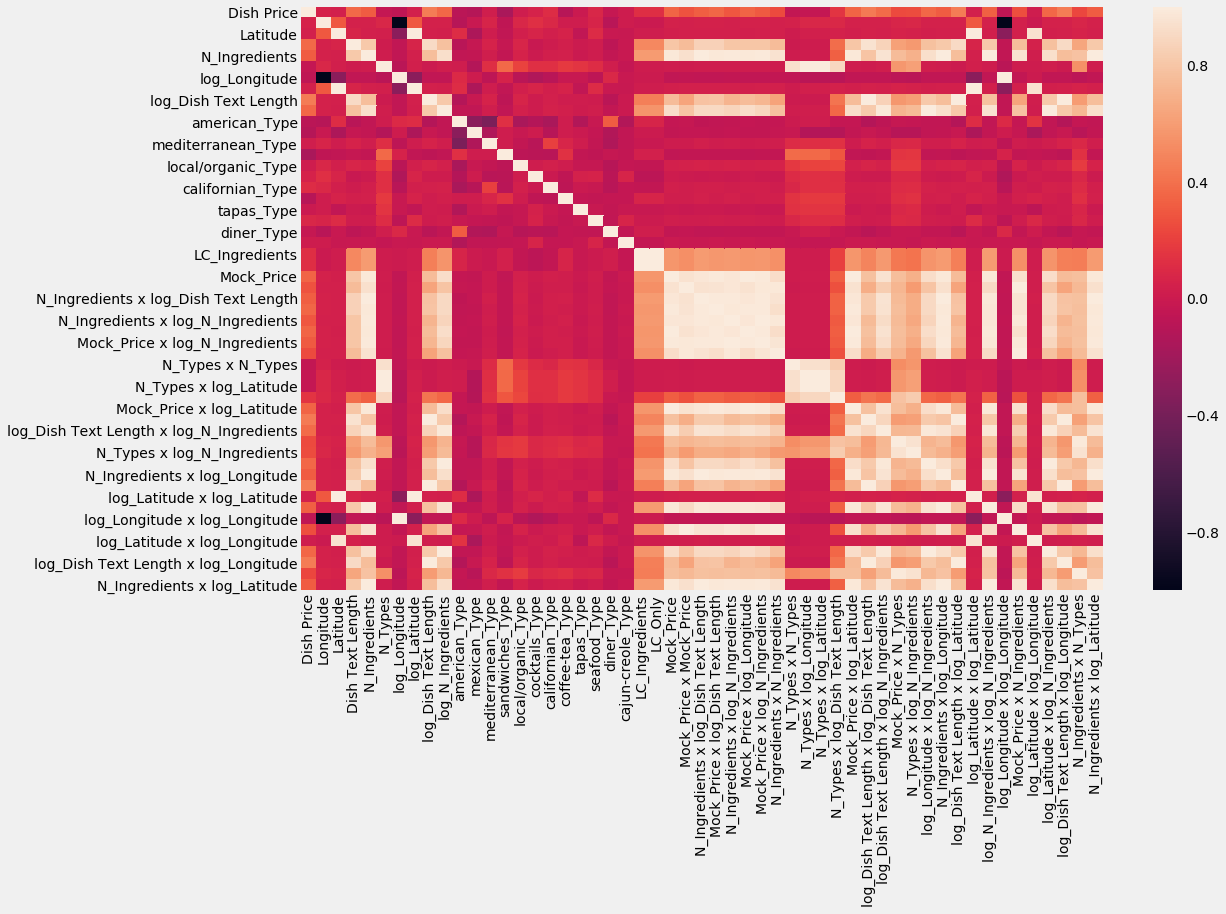

In [881]:
plt.rc('figure', figsize=(16.0, 10.0))
df = pd.concat([y_train, X_train], axis = 1)
sns.heatmap(df.corr())

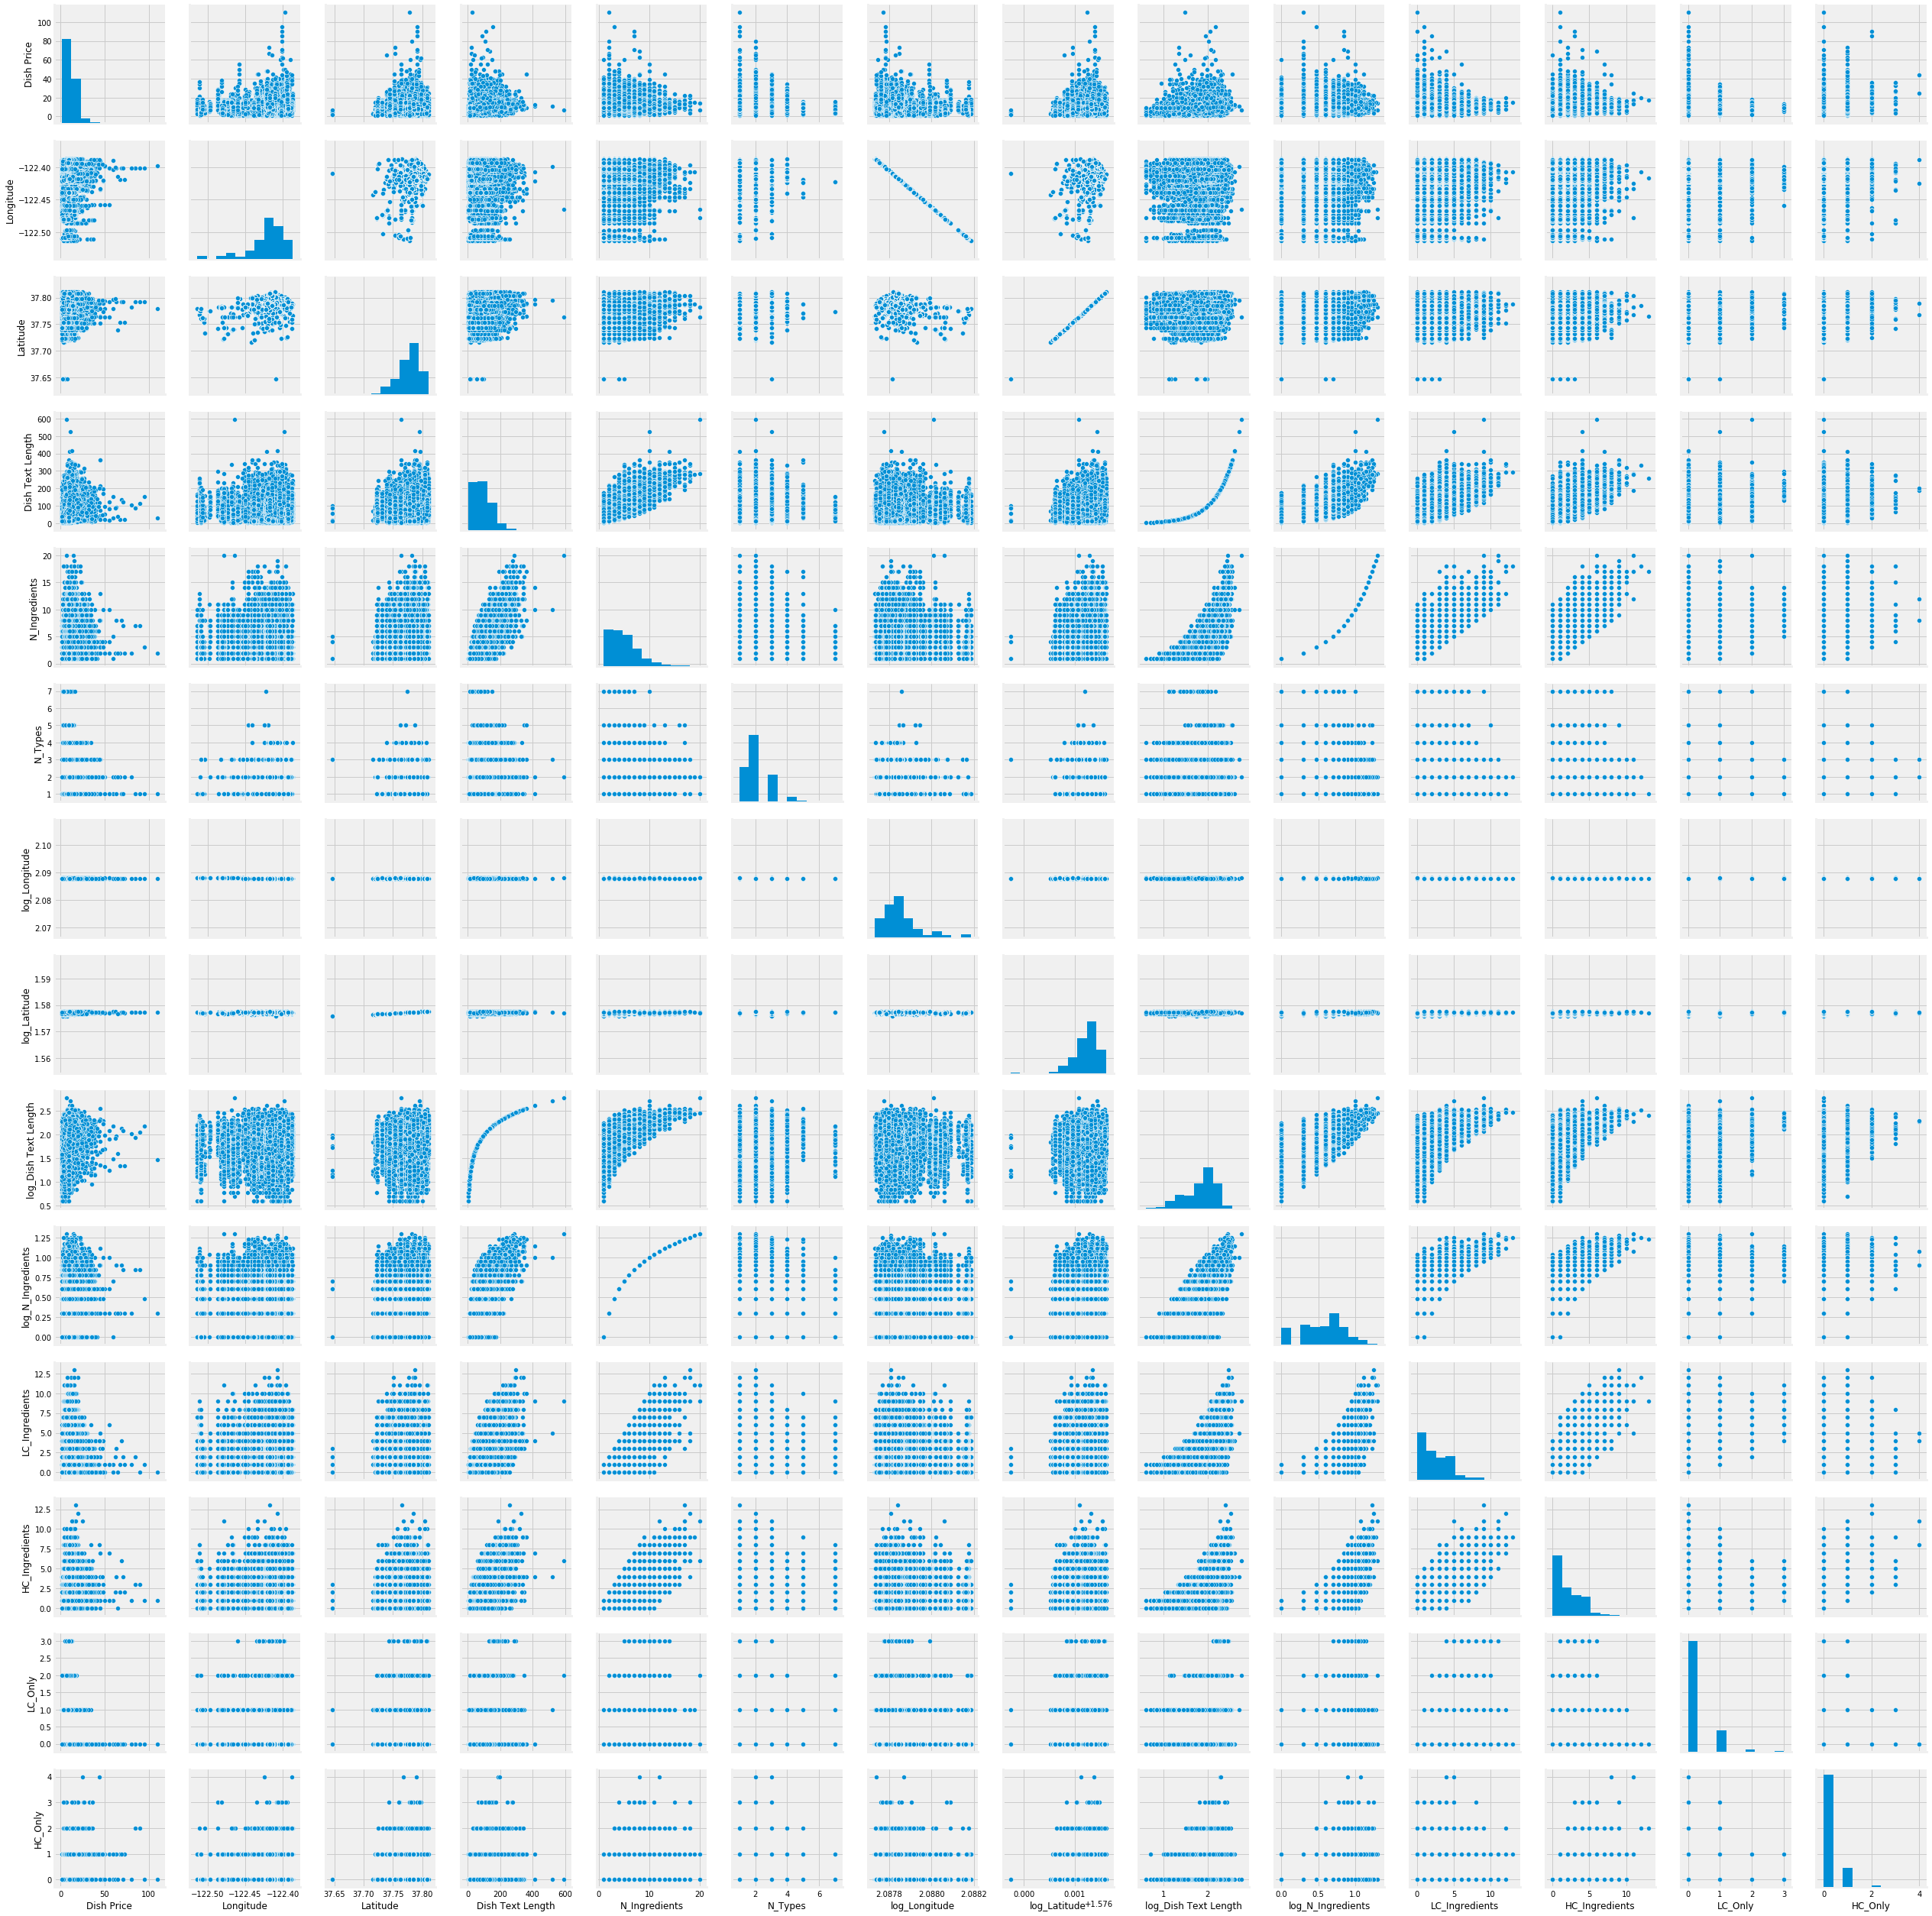

In [673]:
sns.pairplot(model_df)

[0.23062249 0.23755755 0.21930473 0.23440861 0.22853046 0.22257722
 0.21776968 0.24970485 0.24342002 0.23983425]
Mean: 0.2323729838211582
   train_size  train_score  test_score
0         972     0.329285    0.269247
1        3159     0.303276    0.277828
2        5346     0.291400    0.279882
3        7533     0.292190    0.280330
4        9721     0.285781    0.280685


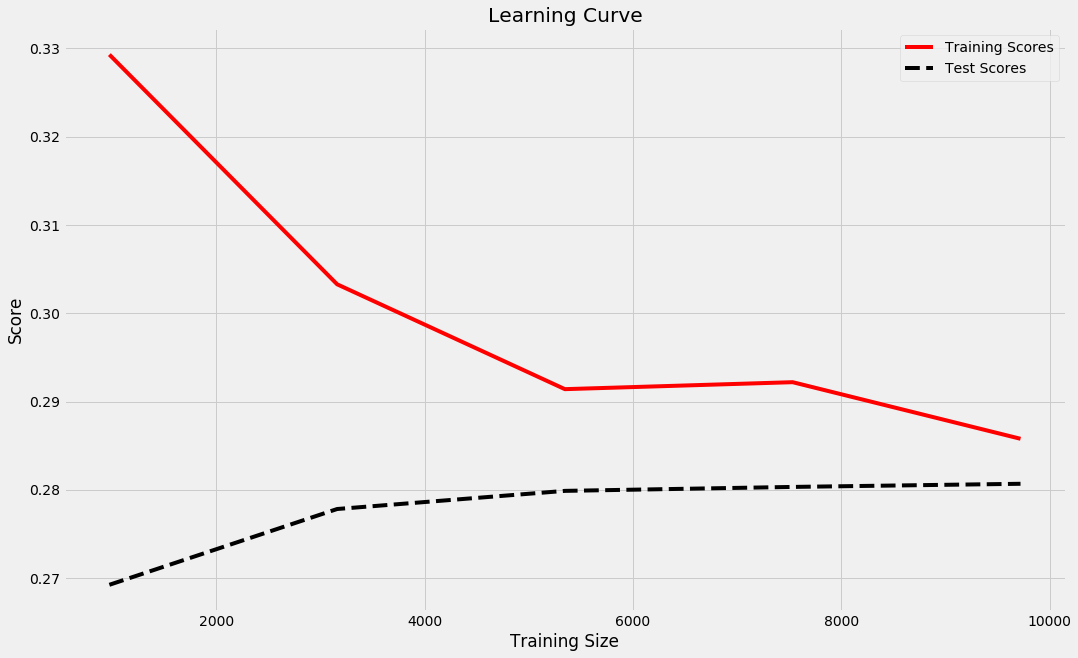

In [836]:
# 10-fold cross-validation
reg = LinearRegression()
scores = cross_val_score(reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(-scores)
print(f'Mean: {np.mean(-scores)}')

train_sizes, train_scores, test_scores = learning_curve(reg, X_train, y_train, cv = 20)
ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)
learn_df = pd.DataFrame({
    'train_size': train_sizes,
    'train_score': ave_train_scores,
    'test_score': ave_test_scores
})

print(learn_df)

plt.plot(learn_df['train_size'].values, learn_df['train_score'].values, 'r-',
        learn_df['train_size'].values, learn_df['test_score'].values, 'k--')
plt.legend(['Training Scores', 'Test Scores'])
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve');
plt.savefig('Learning_Curve.png', format = 'png')

0.22369802469840896


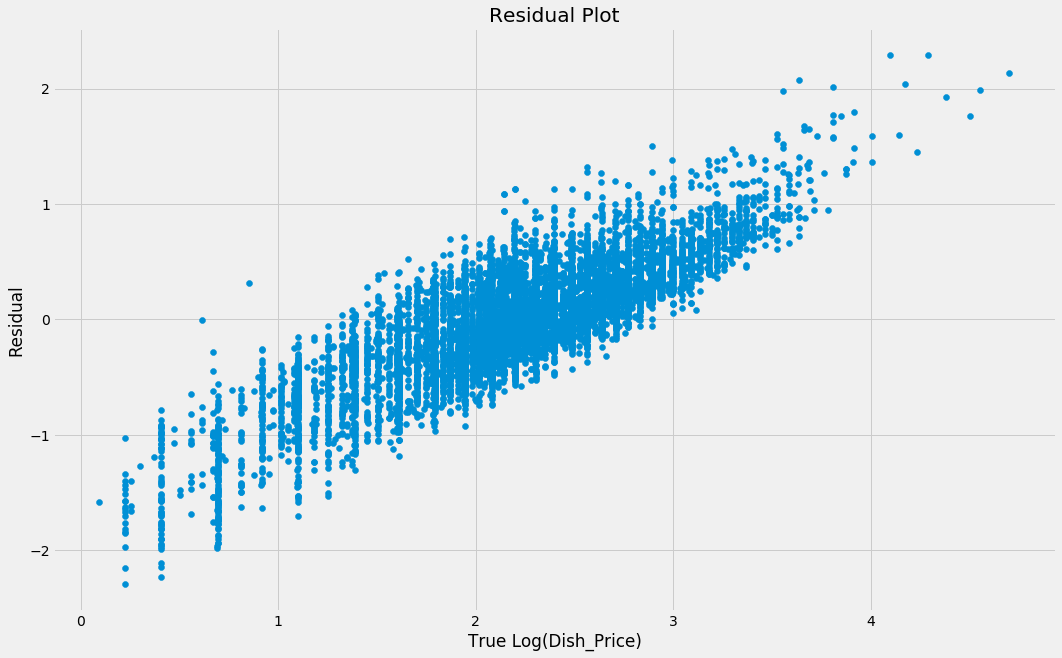

In [917]:
plt.rc('figure', figsize=(16.0, 10.0))
plt.style.use('fivethirtyeight')
y_predict = linmodel.predict(sm.add_constant(X_train))
print(mean_squared_error(y_train, y_predict))
total_residual = y_train - y_predict
plt.scatter(y_train, total_residual)
plt.xlabel('True Log(Dish_Price)')
plt.ylabel('Residual');
plt.title('Residual Plot');
plt.savefig('Residual_Plot.png', format = 'png')

In [878]:
linmodel_wls = sm.WLS(y_train, sm.add_constant(X_train)).fit()
linmodel_wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:             Dish Price   R-squared:                       0.309
Model:                            WLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     90.95
Date:                Mon, 16 Jul 2018   Prob (F-statistic):               0.00
Time:                        18:55:37   Log-Likelihood:                -6858.3
No. Observations:               10233   AIC:                         1.382e+04
Df Residuals:                   10182   BIC:                         1.419e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                       -3.719e+10   1.46e+10     -2.549      0.011   -6.58e+10   -8.59e+09
Longitude                                   -3.867e+07   1.54e+07     -2.513      0.012   -6.88e+07    -8.5e+06
Latitude                                     3.263e+06   1.35e+06      2.416      0.016    6.16e+05    5.91e+06
Dish Text Length                               -0.0058      0.001     -6.092      0.000      -0.008      -0.004
N_Ingredients                                -678.8496    309.280     -2.195      0.028   -1285.100     -72.599
N_Types                                       376.8517    184.254      2.045      0.041      15.678     738.026
log_Longitude                                4.152e+10   1.65e+10      2.513      0.012    9.14e+09    7.39e+10
log_Latitude                                 7.483e+08   3.09e+08      2.424      0.015    1.43e+08    1.35e+09
log_Dish Text Length                          840.7183    668.779      1.257      0.209    -470.219    2151.656
log_N_Ingredients                              -4.9615   1428.805     -0.003      0.997   -2805.702    2795.778
american_Type                                  -0.0563      0.013     -4.468      0.000      -0.081      -0.032
mexican_Type                                   -0.1907      0.017    -10.948      0.000      -0.225      -0.157
mediterranean_Type                             -0.0369      0.016     -2.244      0.025      -0.069      -0.005
sandwiches_Type                                -0.1508      0.018     -8.413      0.000      -0.186      -0.116
local/organic_Type                             -0.0223      0.020     -1.107      0.268      -0.062       0.017
cocktails_Type                                  0.0896      0.022      4.013      0.000       0.046       0.133
californian_Type                                0.1393      0.020      6.950      0.000       0.100       0.179
coffee-tea_Type                                -0.1704      0.020     -8.370      0.000      -0.210      -0.130
tapas_Type                                     -0.1185      0.038     -3.110      0.002      -0.193      -0.044
seafood_Type                                    0.2336      0.032      7.232      0.000       0.170       0.297
diner_Type                                      0.0359      0.018      2.046      0.041       0.002       0.070
cajun-creole_Type                              -0.1151      0.037     -3.140      0.002      -0.187      -0.043
LC_Ingredients                                354.9156    145.307      2.443      0.015      70.086     639.745
LC_Only                                      -354.9476    145.307     -2.443      0.015    -639.778     -70.117
Mock_Price                                   1398.2556    6

0.22369841510348643


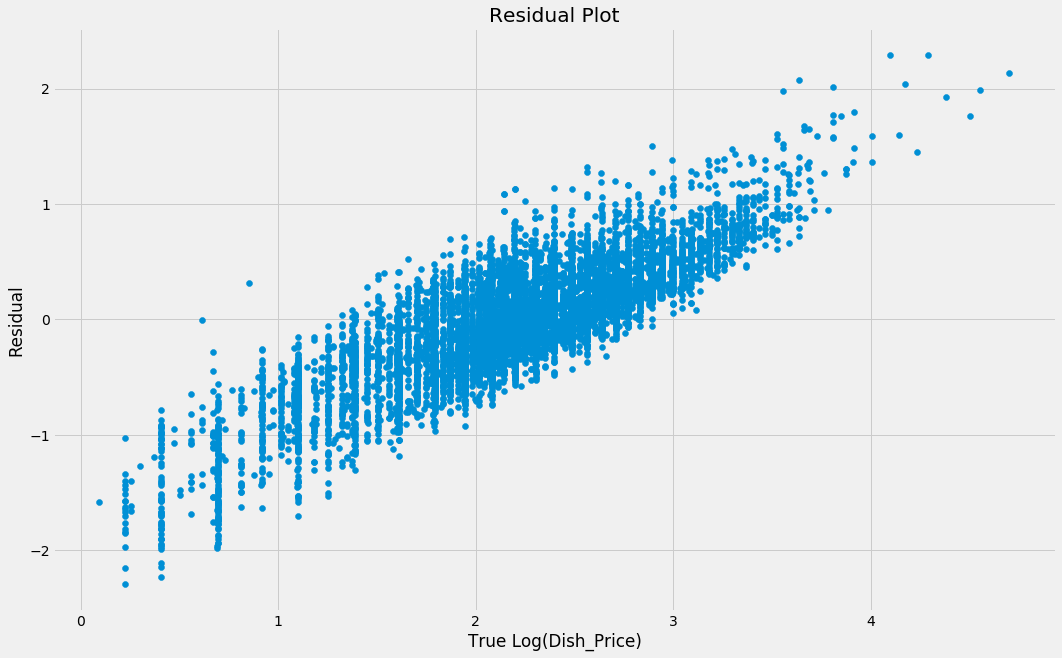

In [874]:
y_predict = linmodel_wls.predict(sm.add_constant(X_train))
print(mean_squared_error(y_train, y_predict))
total_residual = y_train - y_predict
plt.scatter(y_train, total_residual)
plt.xlabel('True Log(Dish_Price)')
plt.ylabel('Residual');
plt.title('Residual Plot');
plt.savefig('Residual_Plot.png', format = 'png')

In [845]:
model_cooks = linmodel.get_influence().cooks_distance[0]
np.flip(np.argsort(model_cooks), 0)[:10]

array([5456, 5426, 2600, 4880, 2668,  350,  739,  474, 1656, 7235])

In [850]:
from sklearn.linear_model import HuberRegressor

In [865]:
for n in np.arange(1.35, 5, 0.5):
    HR = HuberRegressor(epsilon= n)
    HR.fit(X_train, y_train);
    y_predict = HR.predict(X_train)
    print((n, mean_squared_error(y_train, y_predict)))
#total_residual = y_train - y_predict
#plt.scatter(y_train, total_residual)
#plt.xlabel('True Log(Dish_Price)')
#plt.ylabel('Residual');
#plt.title('Residual Plot');

(1.35, 0.23802980889064265)
(1.85, 0.24073050645566021)
(2.35, 0.23547668204010325)
(2.85, 0.23499433806194778)
(3.35, 0.2369398582069178)
(3.85, 0.23827968742200886)
(4.35, 0.23563112028007704)
(4.85, 0.23915895837453685)


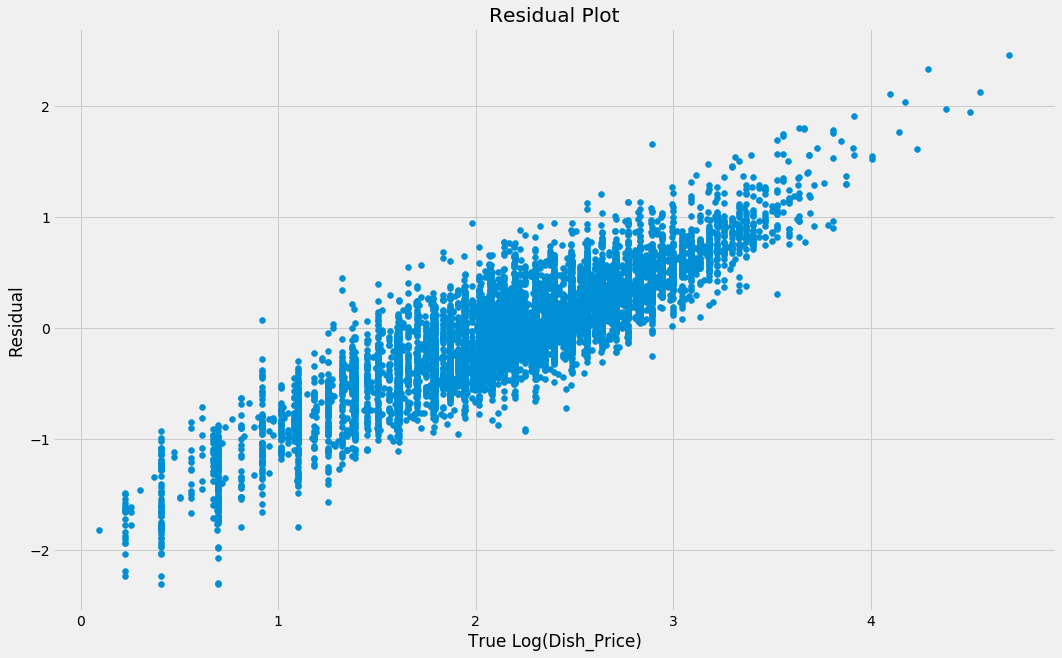

In [866]:
total_residual = y_train - y_predict
plt.scatter(y_train, total_residual)
plt.xlabel('True Log(Dish_Price)')
plt.ylabel('Residual');
plt.title('Residual Plot');

In [812]:
from statsmodels.stats.diagnostic import het_breuschpagan

In [815]:
het_breuschpagan(total_residual, sm.add_constant(X_train))

(528.8487885920565,
 1.8024503098839819e-85,
 13.885879186924315,
 3.257404658888476e-89)

In [ ]:
# weighted least squares, huber loss function

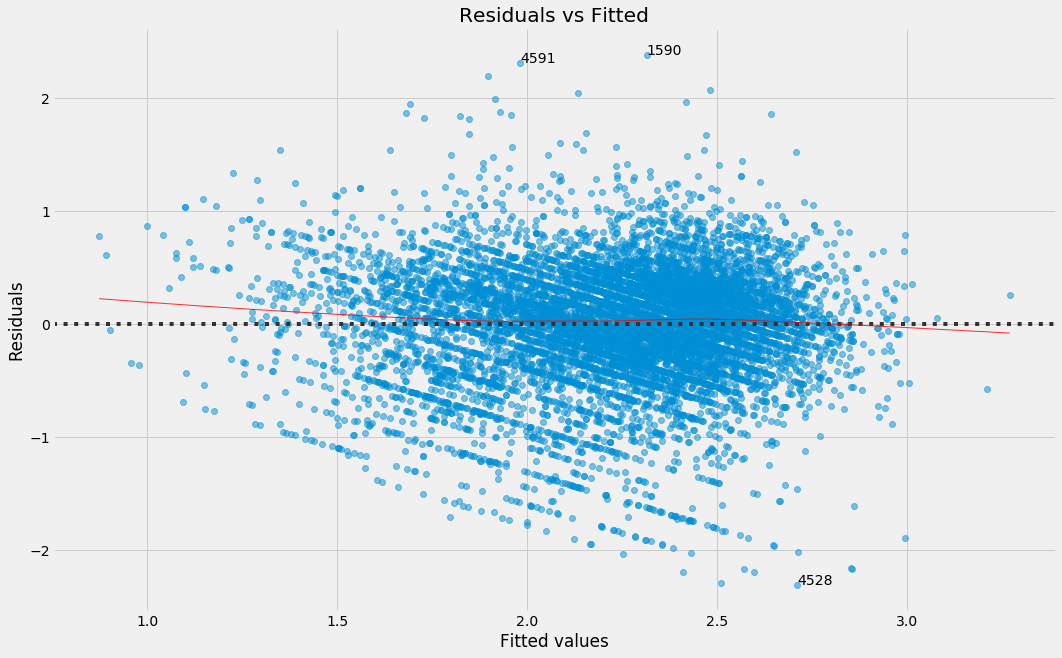

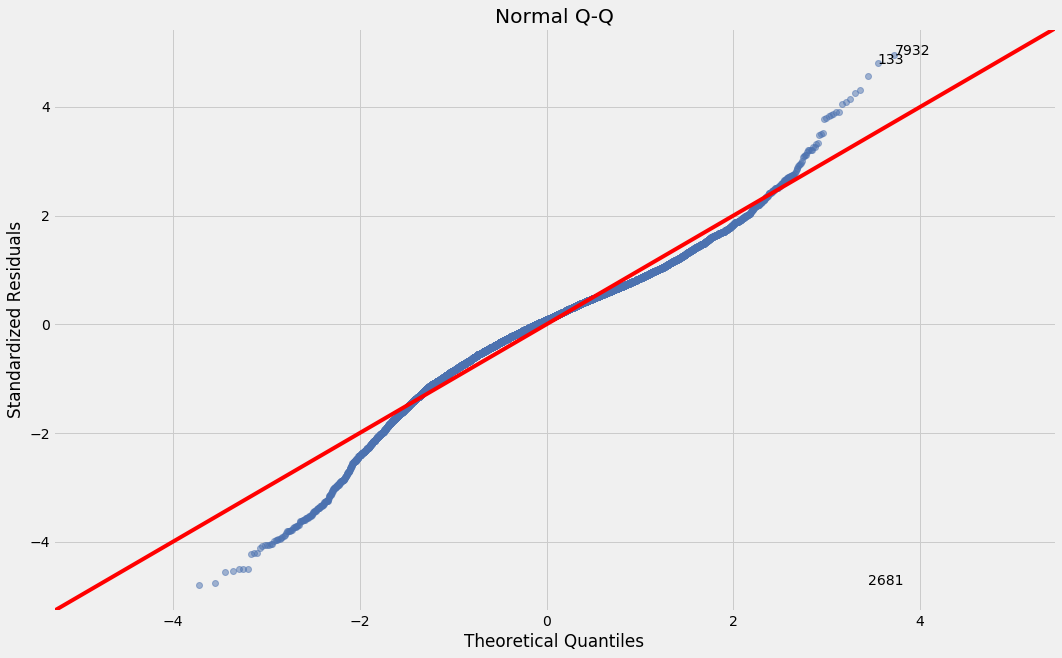

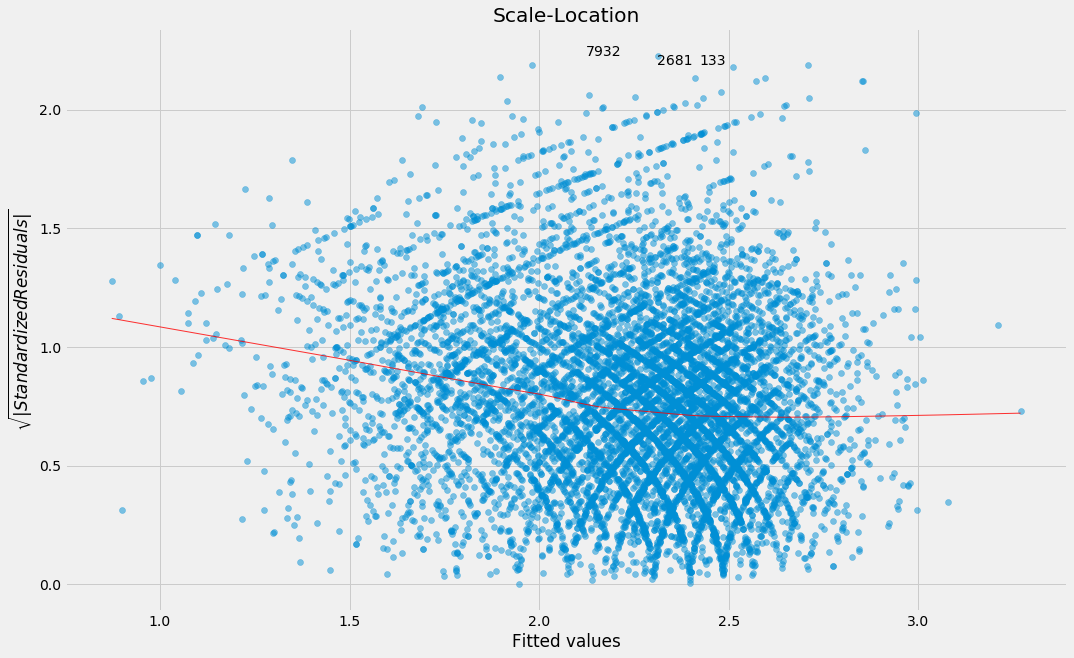

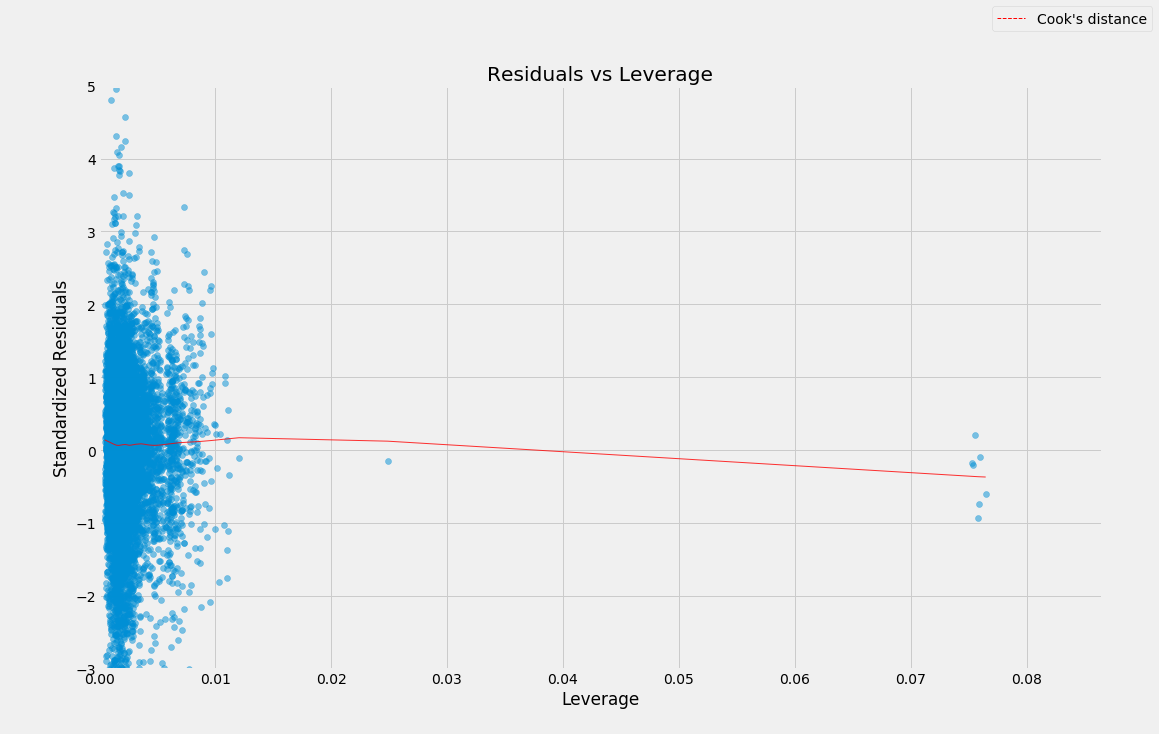

In [837]:
#a = X_train.iloc[4920].name
#X_train.drop(index = a, inplace = True)
#y_train.drop(index = a, inplace = True)
dp_plot.diagnostic_plots(sm.add_constant(X_train), y_train)

In [893]:
from sklearn import feature_selection as f_select
est=LinearRegression()
X = deepcopy(X_train.reset_index(drop = True))
y = deepcopy(y_train.reset_index(drop = True))


kf=KFold(n=len(X),n_folds=10,shuffle=True, random_state = 42)

all_scores=[]

# Instead of using cross_val_score, let's use sklearn.cross_validation.KFold; this will allow
# us to 'manipulate' our training set, 

# get indices of corresponding train & test
for train,test in kf:
    x_train=X.iloc[train]
    y_train=y.iloc[train]
    x_test=X.iloc[test]
    y_test=y.iloc[test]
    pvals=[]
    sig_cols=[]
    
    for feature in x_train.columns:
        pval=f_select.f_regression(x_train[[feature]],y_train)
        if pval[1][0]<.02: 
            sig_cols.append(feature)
            pvals.append(pval[1][0])
            
    est.fit(x_train[sig_cols],y_train)
    r_2=est.score(x_test[sig_cols],y_test)
    all_scores.append(r_2)

IndexError: positional indexers are out-of-bounds

In [892]:
all_scores

[0.3283166489293118,
 0.2855861748942513,
 0.25200733731410996,
 0.3285262006291251,
 0.2769725621770569,
 0.2957806684494323,
 0.29172566012298706,
 0.317204723255772,
 0.30433960989337094,
 0.3155315368774054]

In [ ]:
sns.pairplot(pd.concat([y_vals, X_vals], axis = 1));

## Possible Goal: Topic Modeling

In [29]:
wn.synsets('boodle')[0].definition()

'informal terms for money'